In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from config import PGHOST, PGDATABASE, PGUSER, PGPASSWORD

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

In [2]:
# Define a function to connect to AWS database instance

def connect():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+PGHOST +" port="+ "5432" +" dbname="+PGDATABASE +" user=" + PGUSER \
                  +" password="+ PGPASSWORD
    
    conn = psycopg2.connect(conn_string)
    print("Connected!")

    # Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor

In [3]:
conn, cursor = connect()

Connected!


In [4]:
# Get the data, read SQL query into data frame
bb_data = pd.read_sql_query("SELECT * FROM blackberry", con=conn)
bb_df = pd.DataFrame(bb_data)
bb_df.head()

,Date,open_price,high_price,low_price,close_price,adj_close,volume
0,1999-02-04,2.145833,2.166667,1.895833,1.924479,1.924479,16788600
1,1999-02-05,1.929688,1.947917,1.822917,1.833333,1.833333,3053400
2,1999-02-08,1.854167,1.927083,1.783854,1.812500,1.812500,1548000
3,1999-02-09,1.822917,1.833333,1.656250,1.666667,1.666667,3501600
4,1999-02-10,1.708333,1.708333,1.604167,1.677083,1.677083,1597200


In [5]:
# Check the rows and columns of dfs
print(bb_df.shape)

(5945, 7)


In [6]:
# Check if there is null values
bb_df.isnull().sum()

Date           0
open_price     0
high_price     0
low_price      0
close_price    0
adj_close      0
volume         0
dtype: int64

In [7]:
# Check the data types in df
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5945 entries, 0 to 5944
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         5945 non-null   object 
 1   open_price   5945 non-null   float64
 2   high_price   5945 non-null   float64
 3   low_price    5945 non-null   float64
 4   close_price  5945 non-null   float64
 5   adj_close    5945 non-null   float64
 6   volume       5945 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 325.2+ KB


In [8]:
# change the date column data tpye
bb_df['Date'] = pd.to_datetime(bb_df.Date)
# set date as frame index
bb_df.set_index('Date')
# select data after year 2017
bb_df = bb_df.loc[bb_df.Date >='2017-01-01']

bb_df.head()

,Date,open_price,high_price,low_price,close_price,adj_close,volume
4507,2017-01-03,6.93,7.01,6.86,6.96,6.96,4903000
4508,2017-01-04,7.04,7.15,7.00,7.11,7.11,4255700
4509,2017-01-05,7.13,7.24,7.09,7.12,7.12,3259300
4510,2017-01-06,7.11,7.16,7.04,7.16,7.16,3898000
4511,2017-01-09,7.15,7.19,7.07,7.12,7.12,2898500


In [9]:
bb_df = bb_df.drop(['adj_close','volume'], axis=1)

bb_df.head()

,Date,open_price,high_price,low_price,close_price
4507,2017-01-03,6.93,7.01,6.86,6.96
4508,2017-01-04,7.04,7.15,7.00,7.11
4509,2017-01-05,7.13,7.24,7.09,7.12
4510,2017-01-06,7.11,7.16,7.04,7.16
4511,2017-01-09,7.15,7.19,7.07,7.12


In [10]:
# Create a date series for plotting purpose
date_train = pd.to_datetime(bb_df['Date'])

date_train.head()

4507   2017-01-03
4508   2017-01-04
4509   2017-01-05
4510   2017-01-06
4511   2017-01-09
Name: Date, dtype: datetime64[ns]

In [11]:
# Select "open, high, low, close" as input features

columns = list(bb_df)[1:5]

print(columns)

['open_price', 'high_price', 'low_price', 'close_price']


In [12]:
# Create a new dataframe with only training data - 4 columns

bb_training_df = bb_df[columns].astype(float)

bb_training_df.head()

,open_price,high_price,low_price,close_price
4507,6.93,7.01,6.86,6.96
4508,7.04,7.15,7.00,7.11
4509,7.13,7.24,7.09,7.12
4510,7.11,7.16,7.04,7.16
4511,7.15,7.19,7.07,7.12


In [13]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# scaled the traing dataset

scaler = MinMaxScaler(feature_range=(0,1))
# scaler = StandardScaler()
scaler = scaler.fit(bb_training_df)
scaled_training_data = scaler.transform(bb_training_df)

print(scaled_training_data.shape)

(1438, 4)


In [14]:
# LSTM require to reshape the input data into (n_samples, timesteps, n_features). 
# This project we choose n_features=4 and timesteps = 30 (past days data used for training). 
# Create empty X_train and y_train list 
X_train = []
y_train = []

training_data_len = round(len(scaled_training_data)*0.8)
# Define future days we want to predict and look-back days used for prediction

look_back = 30 # number of days to be used for prediction
num_future_days = 1 # number of days to be prediced

for i in range(look_back, training_data_len-num_future_days+1):
    X_train.append(scaled_training_data[i-look_back:i, 0:scaled_training_data.shape[1]])
    y_train.append(scaled_training_data[i+num_future_days-1:i+num_future_days, 3])

# Create X_test list

X_test = []

for j in range(training_data_len, len(scaled_training_data)-num_future_days+1):
    X_test.append(scaled_training_data[j-look_back:j, 0:scaled_training_data.shape[1]])

In [15]:
X_train, y_train, X_test = np.array(X_train), np.array(y_train), np.array(X_test)

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(1120, 30, 4)
(1120, 1)
(288, 30, 4)


In [17]:
# Build the LSTM model

model = Sequential()

# Add two hidden layers
# model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(LSTM(units=32, activation='relu', return_sequences=False))

model.add(LSTM(units=800, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(LSTM(units=32, return_sequences=True))
model.add(LSTM(units=500, return_sequences=False))
# Add output layer, which contains 1 output
model.add(Dense(units=1))

# Complile the model 
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 800)           2576000   
                                                                 
 lstm_1 (LSTM)               (None, 500)               2602000   
                                                                 
 dense (Dense)               (None, 1)                 501       
                                                                 
Total params: 5,178,501
Trainable params: 5,178,501
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Fit the model

model.fit(X_train, y_train, batch_size =128, epochs=10, verbose=1)

Epoch 1/10
9/9 [==============================] - 15s 1s/step - loss: 0.0596
Epoch 2/10
9/9 [==============================] - 11s 1s/step - loss: 0.0047
Epoch 3/10
9/9 [==============================] - 11s 1s/step - loss: 0.0027
Epoch 4/10
9/9 [==============================] - 11s 1s/step - loss: 0.0018
Epoch 5/10
9/9 [==============================] - 11s 1s/step - loss: 0.0015
Epoch 6/10
9/9 [==============================] - 11s 1s/step - loss: 0.0014
Epoch 7/10
9/9 [==============================] - 11s 1s/step - loss: 0.0013
Epoch 8/10
9/9 [==============================] - 11s 1s/step - loss: 0.0012
Epoch 9/10
9/9 [==============================] - 11s 1s/step - loss: 0.0012
Epoch 10/10
9/9 [==============================] - 11s 1s/step - loss: 0.0012


In [19]:
# Test the model
# Make prediction

prediction = model.predict(X_test)

print(prediction.shape)

9/9 [==============================] - 3s 249ms/step
(288, 1)


In [20]:
#Perform inverse transformation to rescale back to original range
#Since we used 4 variables for transform, the inverse expects same dimensions
#Therefore, we copy our prediction values 4 times and discard them after inverse transform

prediction_copies = np.repeat(prediction, scaled_training_data.shape[1], axis=-1)
print(prediction_copies)

[[0.3164823  0.3164823  0.3164823  0.3164823 ]
 [0.31784254 0.31784254 0.31784254 0.31784254]
 [0.3178612  0.3178612  0.3178612  0.3178612 ]
 ...
 [0.13254921 0.13254921 0.13254921 0.13254921]
 [0.13398626 0.13398626 0.13398626 0.13398626]
 [0.13397971 0.13397971 0.13397971 0.13397971]]


In [21]:
# Discard the extra columns
y_pred = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred.shape)

(288,)


In [22]:
# Create the y_test data to compare with the predictions

close_df = pd.DataFrame({'Date':bb_df['Date'], 'close_price':bb_training_df['close_price']})
y_test = close_df[training_data_len:]
y_test.head()

,Date,close_price
5657,2021-07-29,10.35
5658,2021-07-30,10.16
5659,2021-08-02,10.10
5660,2021-08-03,10.17
5661,2021-08-04,9.87


In [23]:
print(y_test['close_price'].shape)

(288,)


In [24]:
# Calculate the MSE

print(mean_squared_error(y_test['close_price'], y_pred))

2.1247806514924115


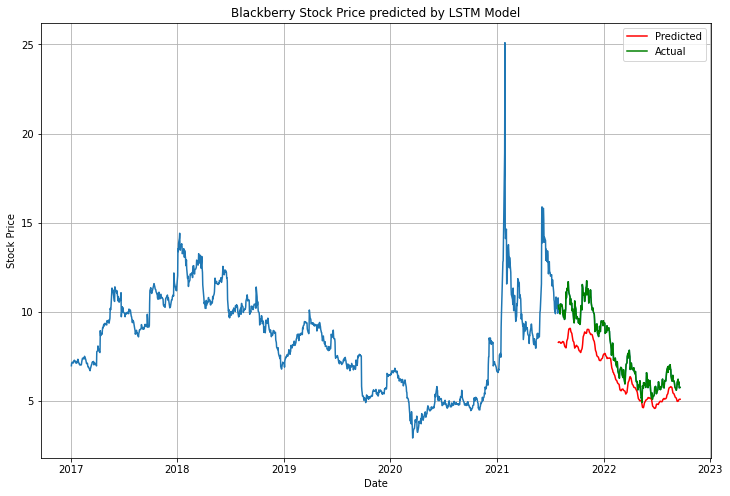

In [25]:
# plot test predictions

plt.figure(figsize=(12, 8))
plt.plot(date_train, bb_training_df['close_price'])
plt.plot(y_test['Date'], y_pred, color='red', label='Predicted')
plt.plot(y_test['Date'], y_test['close_price'], color='green', label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')

plt.title("Blackberry Stock Price predicted by LSTM Model")
plt.grid()
plt.legend()
plt.show()